In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print(f"Epoch {epoch + 1}/{self.params['epochs']} - "
#               f"loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - "
#               f"val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

# pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_csv("data/train.csv", index_col="id")
train.head(5)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


### Pre-processing

In [4]:
Categorical = ["Marital status", 
               "Application mode", 
               "Application order", 
               "Course", 
               "Previous qualification", 
               "Nacionality", 
               "Mother's qualification", 
               "Father's qualification", 
               "Mother's occupation", 
               "Father's occupation"]
Boolean = ["Daytime/evening attendance", 
           "Displaced", 
           "Educational special needs", 
           "Debtor", 
           "Tuition fees up to date", 
           "Gender", 
           "Scholarship holder", 
           "International" ]
Continuous = ["Previous qualification (grade)", 
              "Admission grade", 
              "Age at enrollment", 
              "Curricular units 1st sem (credited)", 
              "Curricular units 1st sem (enrolled)", 
              "Curricular units 1st sem (evaluations)", 
              "Curricular units 1st sem (approved)", 
              "Curricular units 1st sem (grade)", 
              "Curricular units 1st sem (without evaluations)",
              "Curricular units 2nd sem (credited)", 
              "Curricular units 2nd sem (enrolled)", 
              "Curricular units 2nd sem (evaluations)", 
              "Curricular units 2nd sem (approved)", 
              "Curricular units 2nd sem (grade)", 
              "Curricular units 2nd sem (without evaluations)",
              "Unemployment rate",
              "Inflation rate",
              "GDP"]

In [5]:
# One-hot encode categorical columns
train = pd.get_dummies(train, columns=Categorical)

# Scale continuous columns
train[Continuous] = (train[Continuous] - train[Continuous].mean()) / train[Continuous].std()

# Separate features and target
X = train.drop('Target', axis=1)
y = train['Target']

# One-hot encode the target variable if it is categorical
y = pd.get_dummies(y)

### Modelling

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [37]:
# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    """
    Exponentially weighted decayer.
    """
    decay_rate = 0.8
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lambda_reg = 0.001

model = Sequential([
    Input((X_train.shape[1],)),
    Dense(20, activation='tanh', kernel_regularizer=l2(lambda_reg), name='Hidden_Layer_1'),
    Dense(10, activation='tanh', kernel_regularizer=l2(lambda_reg), name='Hidden_Layer_2'),
    Dense(6, activation='tanh', kernel_regularizer=l2(lambda_reg), name='Hidden_Layer_3'),
    #Dense(5, activation='tanh', kernel_regularizer=l2(lambda_reg), name='Hidden_Layer_3'),
    Dense(y_train.shape[1], activation='softmax', name='Output_Layer')  # For categorical target
])

# Compile the model with Adam optimizer and initial learning rate
initial_learning_rate = 0.005
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Fit the model with the custom callback for learning rate scheduling
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[LearningRateScheduler(lr_scheduler, verbose=0)])

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)               │ (None, 20)                  │           5,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_2 (Dense)               │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_3 (Dense)               │ (None, 6)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 3)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,117 (23.89 KB)

 Trainable params: 6,117 (23.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 882us/step - accuracy: 0.7936 - loss: 0.5790 - val_accuracy: 0.8182 - val_loss: 0.5003 - learning_rate: 0.0050
Epoch 2/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.8193 - loss: 0.4875 - val_accuracy: 0.8205 - val_loss: 0.4861 - learning_rate: 0.0050
Epoch 3/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.8225 - loss: 0.4827 - val_accuracy: 0.8165 - val_loss: 0.4939 - learning_rate: 0.0050
Epoch 4/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.8234 - loss: 0.4798 - val_accuracy: 0.8206 - val_loss: 0.4883 - learning_rate: 0.0050
Epoch 5/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.8241 - loss: 0.4768 - val_accuracy: 0.8149 - val_loss: 0.4926 - learning_rate: 0.0050
Epoch 6/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8198 - loss: 0.4837 - val_accuracy: 0.8236 - val_loss: 0.4788 - learning_rate: 0.0050
Epoch 7/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.8

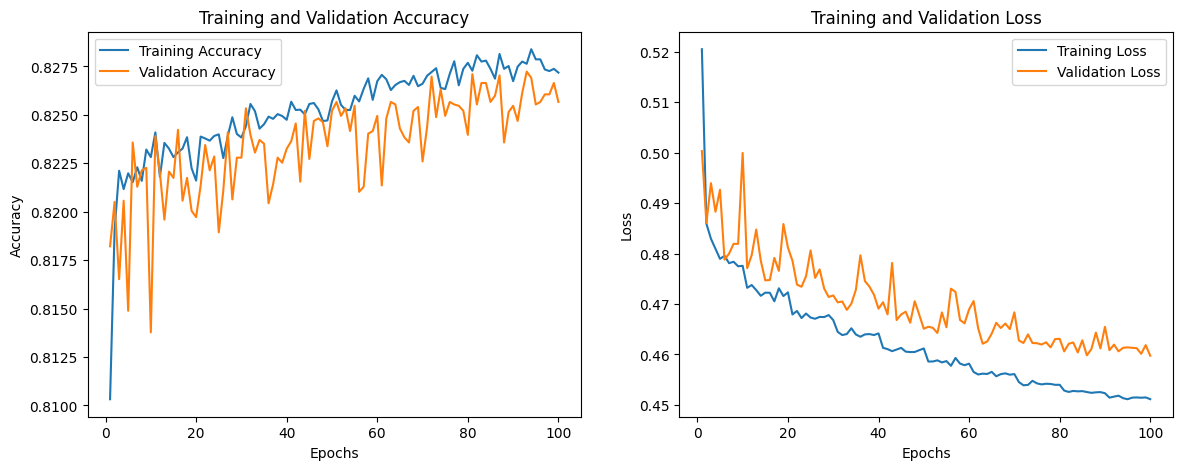

In [38]:
# Plot training & validation accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()